In [1]:
import numpy as np
import scipy.signal 
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
import scipy.io.wavfile
import io 
from IPython.display import Image

# 1. Defining cpp_function

In [2]:
# function for computing cepstral peak prominence

def cpp_function(x, fs, pitch_range, trendline_quefrency_range):
    """
    Computes cepstral peak prominence for a given signal 

    Parameters
    -----------
    x: ndarray
        The audio signal
    fs: integer
        The sampling frequency
    pitch_range: list of 2 elements
        The pitch range where a peak is searched for
    trendline_quefrency_range: list of 2 elements
        The quefrency range for which the amplitudes will be modelled by a straight line

    Returns
    -----------
    integer
        The cepstral peak prominence of the audio signal
    """
    # Cepstrum
    x = np.hamming(len(x))*x
    spectrum = np.fft.rfft(x)
    spectrum = 20*np.log10(np.abs(spectrum))
    ceps = np.fft.rfft(spectrum)
    ceps = 20*np.log10(np.abs(ceps))

    # Quefrency
    dt = 1/fs
    freq_vector = np.fft.rfftfreq(len(x), d=dt)
    df = freq_vector[1] - freq_vector[0]
    quefrency_vector = np.fft.rfftfreq(2*ceps.size-2, df)
    
    # Selecting part of cepstrum
    quefrency_range = [1/pitch_range[1], 1/pitch_range[0]]
    index_range = np.where((quefrency_vector >= quefrency_range[0]) & (quefrency_vector <=quefrency_range[1]))
    
    # For trend line
    index_range_tl = np.where((quefrency_vector >= trendline_quefrency_range[0]) & (quefrency_vector <=trendline_quefrency_range[1]))
    
    # Linear regression
    linear_regressor = LinearRegression()  
    linear_regressor.fit(quefrency_vector[index_range_tl].reshape(-1, 1), ceps[index_range_tl].reshape(-1, 1))  
    Y_pred = linear_regressor.predict(quefrency_vector.reshape(-1, 1))  
    
    # CPP
    peak_value = np.max(ceps[index_range])
    peak_index = np.argmax(ceps[index_range])
    cpp = peak_value - Y_pred[index_range][peak_index][0]

    return cpp



# 2. Defining cpp_plot

To plot the cepstrum and look at the cepstral peak prominence

In [3]:
# function for plotting cepstral peak prominence

def cpp_plot(x, fs, pitch_range, trendline_quefrency_range):
    
    # Cepstrum
    x = np.hamming(len(x))*x
    spectrum = np.fft.rfft(x)
    spectrum = 20*np.log10(np.abs(spectrum))
    ceps = np.fft.rfft(spectrum)
    ceps = 20*np.log10(np.abs(ceps))

    # Quefrency
    dt = 1/fs
    freq_vector = np.fft.rfftfreq(len(x), d=dt)
    df = freq_vector[1] - freq_vector[0]
    quefrency_vector = np.fft.rfftfreq(2*ceps.size-2, df)
    # quefrency_vector = np.fft.rfftfreq(np.log(np.abs(spectrum)).size, df)
    
    # Selecting part of cepstrum
    quefrency_range = [1/pitch_range[1], 1/pitch_range[0]]
    index_range = np.where((quefrency_vector >= quefrency_range[0]) & (quefrency_vector <=quefrency_range[1]))

    # For trend line
    index_range_tl = np.where((quefrency_vector >= trendline_quefrency_range[0]) & (quefrency_vector <=trendline_quefrency_range[1]))
    plot_range = np.where((quefrency_vector >= 0) & (quefrency_vector <= 0.0512))
    
    # Linear regression
    linear_regressor = LinearRegression()  
    linear_regressor.fit(quefrency_vector[index_range_tl].reshape(-1, 1), ceps[index_range_tl].reshape(-1, 1))  
    Y_pred = linear_regressor.predict(quefrency_vector.reshape(-1, 1))  
    
    peak_value = np.max(ceps[index_range])
    peak_index = np.argmax(ceps[index_range])

    fig, ax = plt.subplots(1,1, figsize=(12,8))
    ax.plot(quefrency_vector[plot_range], ceps[plot_range])
    ax.plot(quefrency_vector[plot_range], Y_pred[plot_range])
    
    ax.plot(quefrency_vector[index_range][peak_index], peak_value, marker="o",markeredgecolor="red", markerfacecolor="red")
    ax.plot(quefrency_vector[index_range][peak_index], Y_pred[index_range][peak_index], marker="o", markeredgecolor="red", markerfacecolor="red")
    ax.set_xlabel('quefrency[s]')
    ax.set_ylabel('log magnitude(dB)')
    ax.set_title('Cepstrum')
    
    print('The peaks are searched for between quefrencies {}s and {}s'.format(np.round(quefrency_vector[index_range][0],5), np.round(quefrency_vector[index_range][-1], 5)))
    print('The peak is found at quefrency {}s and its value is {}'.format(np.round(quefrency_vector[index_range][peak_index], 5), np.round(peak_value, 5)))
    print('The trendline value at this quefrency is {}'.format(np.round(Y_pred[index_range][peak_index][0], 5)))
    print('The trendline is trained on quefrencies between {}s and {}s'.format(np.round(quefrency_vector[index_range_tl][0],5),  np.round(quefrency_vector[index_range_tl][-1],5)))
    print('The CPP is {} dB'.format(np.round(peak_value - Y_pred[index_range][peak_index][0], 5)))
    


In [5]:
#for rainbow.wav
fs, signal = scipy.io.wavfile.read('audio_files/data_input_rainbow.wav')
print(cpp_function(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05]))

15.495525241099678


The peaks are searched for between quefrencies 0.00304s and 0.01664s
The peak is found at quefrency 0.00907s and its value is 78.54759
The trendline value at this quefrency is 63.05206
The trendline is trained on quefrencies between 0.00104s and 0.04998s
The CPP is 15.49553 dB


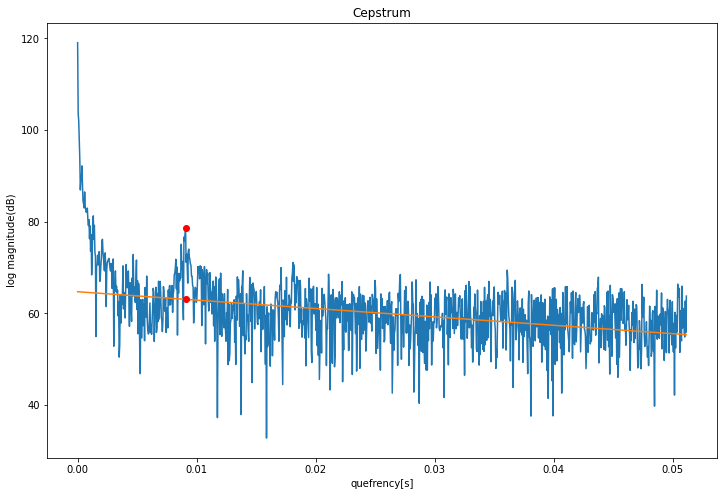

In [6]:
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05])

# 3. Making plots for each step

## 3.1 Waveform

Text(0.5, 1.0, 'Waveform after hamming')

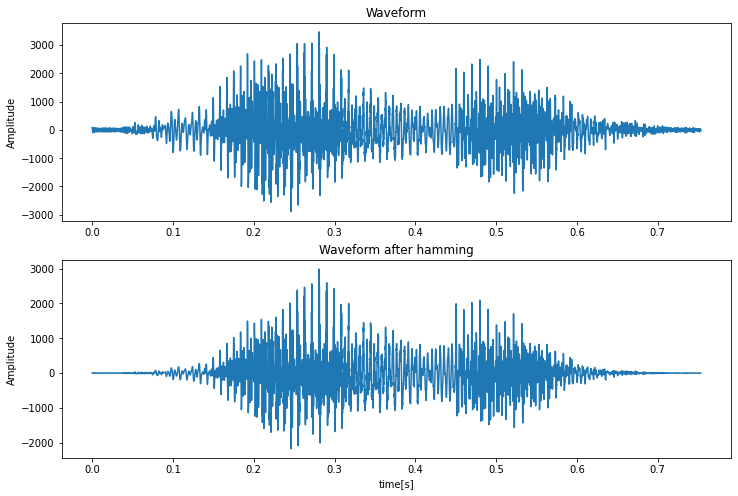

In [8]:
fs, signal = scipy.io.wavfile.read('audio_files/data_input_rainbow.wav')

fig, ax = plt.subplots(2,1, figsize=(12,8))
audio_length = len(signal)/fs 
timeaxis = np.linspace(0,audio_length,len(signal))

ax[0].plot(timeaxis, signal)
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Waveform')

signal = np.hamming(len(signal))*signal

ax[1].plot(timeaxis, signal)
ax[1].set_xlabel('time[s]')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Waveform after hamming')

## 3.2 Spectrum

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 5000.0)

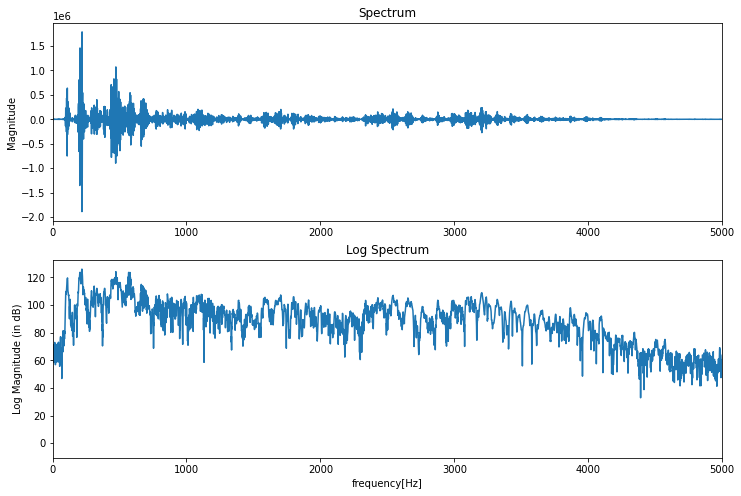

In [9]:
spectrum = np.fft.rfft(signal)
dt = 1/fs
freq_vector = np.fft.rfftfreq(len(signal), d=dt)

fig, ax = plt.subplots(2,1, figsize=(12,8))

ax[0].plot(freq_vector, spectrum)
ax[0].set_ylabel('Magnitude')
ax[0].set_title('Spectrum')

spectrum = 20*np.log10(np.abs(spectrum))

ax[1].plot(freq_vector, spectrum)
ax[1].set_xlabel('frequency[Hz]')
ax[1].set_ylabel('Log Magnitude (in dB)')
ax[1].set_title('Log Spectrum')

ax[0].set_xlim(0, 5000)
ax[1].set_xlim(0, 5000)

## 3.3 Cepstrum (in dB)

Text(0.5, 1.0, 'Cepstrum')

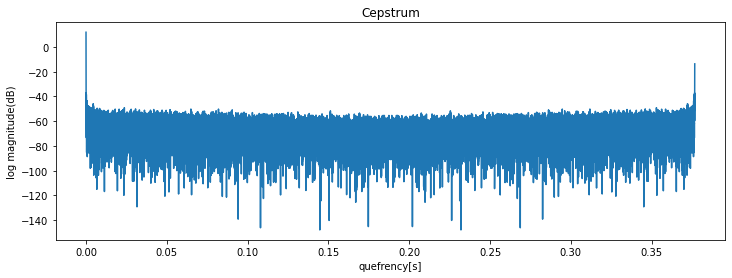

In [10]:
ceps = np.fft.irfft(np.log(np.abs(spectrum)))
ceps = 20*np.log10(abs(ceps))
df = freq_vector[1] - freq_vector[0]
quefrency_vector = np.fft.rfftfreq(2*ceps.size-2, df)

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(quefrency_vector, ceps)
ax.set_xlabel('quefrency[s]')
ax.set_ylabel('log magnitude(dB)')
ax.set_title('Cepstrum')

## 3.4 Cepstrum and trendline in the given pitch range and trendline range

The peaks are searched for between quefrencies 0.00304s and 0.01664s
The peak is found at quefrency 0.00907s and its value is 78.54759
The trendline value at this quefrency is 63.05206
The trendline is trained on quefrencies between 0.00104s and 0.04998s
The CPP is 15.49553 dB


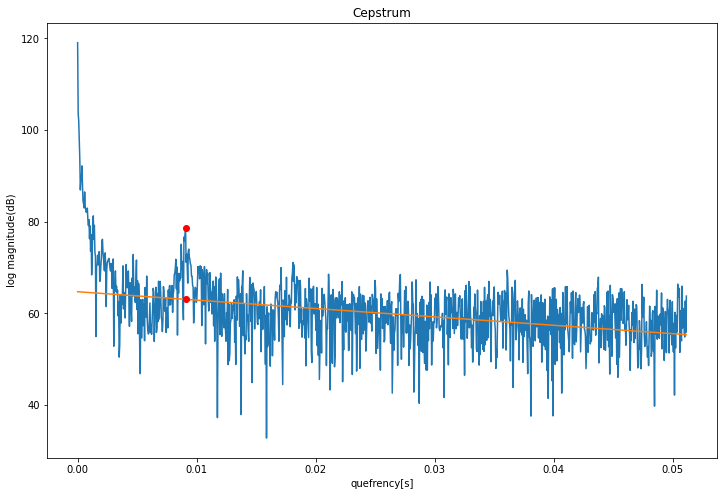

In [12]:
fs, signal = scipy.io.wavfile.read('audio_files/data_input_rainbow.wav')
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05])

# 4 Comparing results with Praat 

Using the parameters described in the page for Powerspectrum (https://www.fon.hum.uva.nl/praat/manual/PowerCepstrum__Get_peak_prominence___.html)<BR>
Could also use parameters described in Murton et al.



## Example 1: rainbow.wav

Using rainbow.wav (from https://github.com/danielmlow/vfp/tree/master/data/input)<BR>
CPP = 15.44 dB

### a) Praat

In [13]:
# Using script:
"""
select Sound data_input_rainbow
To PowerCepstrogram: 60, 0.002, 5000, 50
To PowerCepstrum (slice): 0.1
prominence = Get peak prominence: 60, 333.3, "parabolic", 0.001, 0.05, "straight", "robust slow"
Text top: "no", "Peak prominence = " + fixed$ (prominence, 2) + " dB"
Draw: 0, 0, 0, 110, "yes"
Colour: "blue"
Draw trend line: 0, 0, 0, 110, 0.001, 0.05, "straight", "robust slow"
Colour: "black"
Text top: "no", "Peak prominence = " + fixed$ (prominence, 2) + " dB"
""";

In [15]:
Image(url="cpp_praat_for_audio_files/rainbow.png", width=500, height=500)

### b) cpp_function

The peaks are searched for between quefrencies 0.00304s and 0.01664s
The peak is found at quefrency 0.00907s and its value is 78.54759
The trendline value at this quefrency is 63.05206
The trendline is trained on quefrencies between 0.00104s and 0.04998s
The CPP is 15.49553 dB


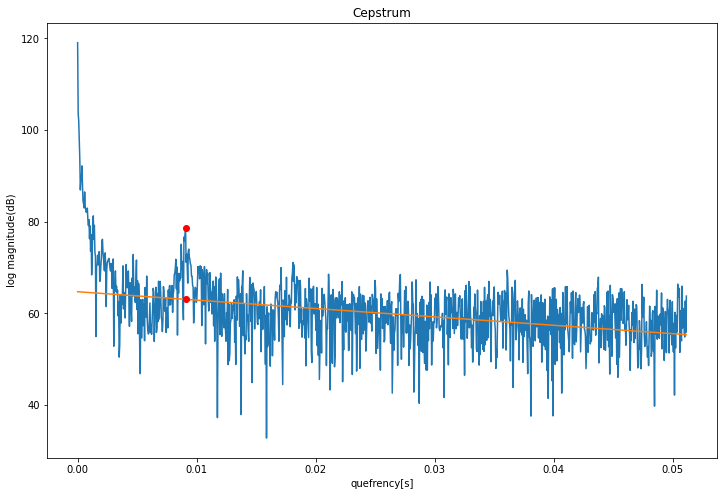

In [16]:
fs, signal = scipy.io.wavfile.read('audio_files/data_input_rainbow.wav')
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05])

## Example 2: CantinaBand3.wav

Using CantinaBand3.wav (from https://www2.cs.uic.edu/~i101/SoundFiles/) <BR>
CPP = 9.17 dB

### a) Praat

In [17]:
# Using script:
"""
select Sound sweep
To PowerCepstrogram: 60, 0.002, 5000, 50
To PowerCepstrum (slice): 0.1
prominence = Get peak prominence: 60, 333.3, "parabolic", 0.001, 0.05, "straight", "robust slow"
Text top: "no", "Peak prominence = " + fixed$ (prominence, 2) + " dB"
Draw: 0, 0, 0, 110, "yes"
Colour: "blue"
Draw trend line: 0, 0, 0, 110, 0.001, 0.05, "straight", "robust slow"
Colour: "black"
Text top: "no", "Peak prominence = " + fixed$ (prominence, 2) + " dB"
""";

In [18]:
Image(url="cpp_praat_for_audio_files/CantinaBand3.png", width=500, height=500)

### b) cpp_function

The peaks are searched for between quefrencies 0.00308s and 0.0166s
The peak is found at quefrency 0.00345s and its value is 87.09498
The trendline value at this quefrency is 74.90381
The trendline is trained on quefrencies between 0.00109s and 0.04998s
The CPP is 12.19117 dB


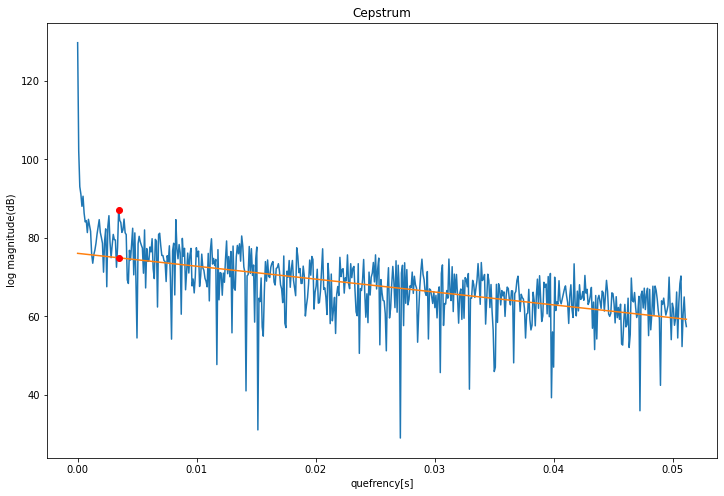

In [19]:
fs, signal = scipy.io.wavfile.read('audio_files/CantinaBand3.wav')
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05])

## Example 3: StarWars3.wav

Using StarWars3.wav (from https://www2.cs.uic.edu/~i101/SoundFiles/) <BR>
CPP = 25.56 dB

### a) Praat

In [20]:
# Using script:
"""
select Sound StarWars3
To PowerCepstrogram: 60, 0.002, 5000, 50
To PowerCepstrum (slice): 0.1
prominence = Get peak prominence: 60, 333.3, "parabolic", 0.001, 0.05, "straight", "robust slow"
Text top: "no", "Peak prominence = " + fixed$ (prominence, 2) + " dB"
Draw: 0, 0, 0, 110, "yes"
Colour: "blue"
Draw trend line: 0, 0, 0, 110, 0.001, 0.05, "straight", "robust slow"
Colour: "black"
Text top: "no", "Peak prominence = " + fixed$ (prominence, 2) + " dB"
""";


In [21]:
Image(url="cpp_praat_for_audio_files/starwars.png", width=500, height=500)

### b) cpp_function

The peaks are searched for between quefrencies 0.00308s and 0.0166s
The peak is found at quefrency 0.00426s and its value is 89.43276
The trendline value at this quefrency is 71.88985
The trendline is trained on quefrencies between 0.00109s and 0.04998s
The CPP is 17.54291 dB


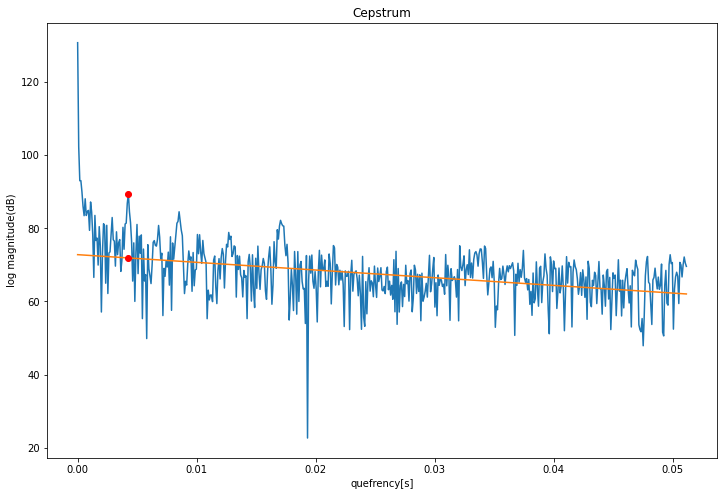

In [22]:
fs, signal = scipy.io.wavfile.read('audio_files/StarWars3.wav')
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3], trendline_quefrency_range=[0.001, 0.05])

# 5 Need to work on:

- <B>Parameters in cpp_function:</B> Could use more parameters for more accurate plots
- <B>Smoothing:</B> Could use smoothing like in the matlab implementation
- <B>Examples:</B> More/better example audio files
